# Music Genre Classification using Neural Network


In [1]:
import pandas as pd
import numpy as np
import platform
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, ReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Accuracy, AUC, F1Score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        if tf.test.is_built_with_cuda():
            print(
                f"CUDA is enabled. Using GPU(s) with CUDA: {physical_devices}")
        elif platform.system() == 'Darwin':
            print(
                f"Metal is enabled. Using Metal-enabled GPU on macOS: {physical_devices}")
        else:
            print(
                f"GPU detected but neither CUDA nor Metal is enabled: {physical_devices}")
    except RuntimeError as e:
        print(f"Error enabling GPU acceleration: {e}")
else:
    print("No GPU found. Running on CPU.")

Metal is enabled. Using Metal-enabled GPU on macOS: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# Load MFCC data
mfcc_df = pd.read_csv('mfcc_data_fma_v1.csv', header=[0, 1], index_col=0)
labels = pd.read_csv('../project_data/tracks_fma.csv')['genre']

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# # Drop non-numeric columns
# mfcc_df = mfcc_df.drop(columns=['track_id'])

# Flatten multi-index columns and scale features
mfcc_df.columns = ['_'.join(map(str, col)) for col in mfcc_df.columns]
scaler = StandardScaler()
X = scaler.fit_transform(mfcc_df)

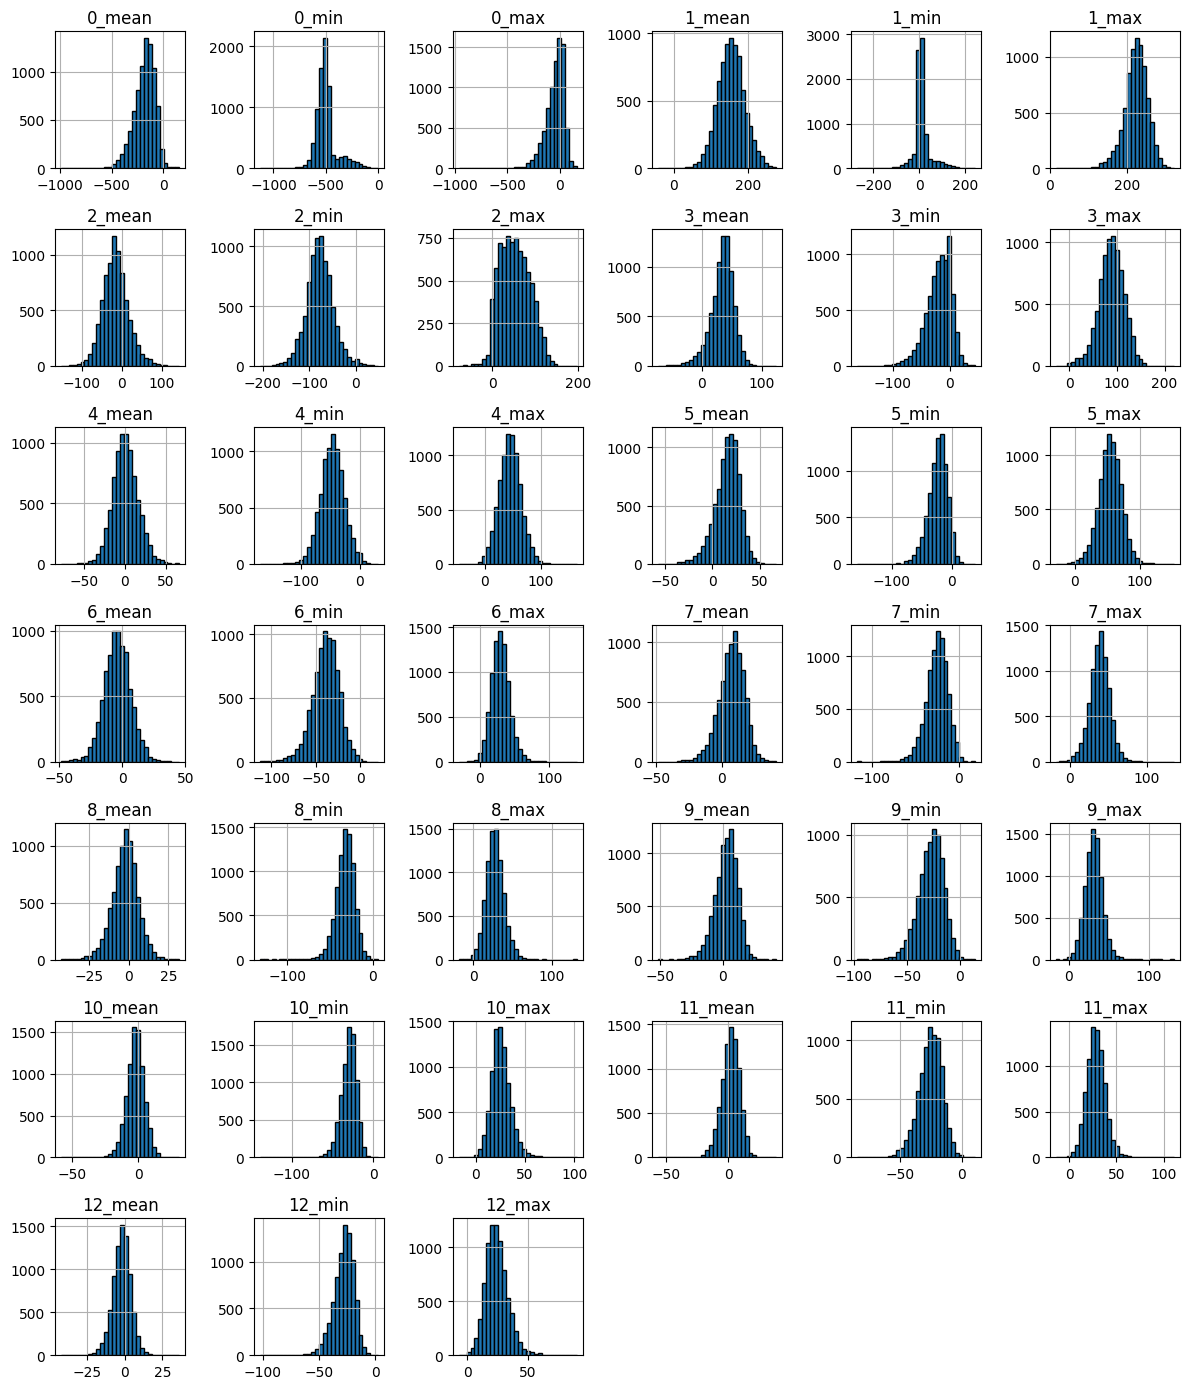

In [6]:
mfcc_df.hist(bins=30, figsize=(12, 14), edgecolor='black')
plt.tight_layout()
plt.show()

In [7]:
y = to_categorical(y, num_classes=8)

In [8]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y.argmax(axis=1),
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2,
    stratify=y_train_full.argmax(axis=1),
    random_state=42
)

In [9]:
x_train_nan = np.isnan(X_train).sum()  # Liczba NaN w X_train
y_train_nan = np.isnan(y_train).sum()  # Liczba NaN w y_train

print(f"NaN values in X_train: {x_train_nan}")
print(f"NaN values in y_train: {y_train_nan}")

NaN values in X_train: 0
NaN values in y_train: 0


In [12]:
def build_and_train_model(X_train, y_train, X_val, y_val,
                          hidden_layers=[64, 32],
                          output_activation='softmax',
                          loss='categorical_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy', Precision(name='precision')],
                          monitor_metric='val_precision',
                          model_path='best_model.h5',
                          epochs=20,
                          batch_size=32,
                          patience=5,
                          dropout=0.2):

    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(hidden_layers[0]))
    model.add(LeakyReLU(negative_slope=0.1))
    for units in hidden_layers[1:]:
        model.add(Dense(units))
        model.add(LeakyReLU(negative_slope=0.1))
        model.add(BatchNormalization())
        model.add(Dropout(dropout)),
    model.add(Dense(8, activation=output_activation))

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    checkpoint = ModelCheckpoint(
        model_path,
        monitor=monitor_metric,
        mode='min',
        save_best_only=True,
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor=monitor_metric,
        patience=patience,
        mode='min',
        verbose=1,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[checkpoint, early_stopping]
    )

    return model, history

In [13]:
model, history = build_and_train_model(
    X_train, y_train,
    X_val, y_val,
    hidden_layers=[256, 128, 64],
    optimizer=Adam(learning_rate=0.0001),
    metrics=[AUC(), F1Score(), 'accuracy', Precision(name='precision')],
    monitor_metric='val_loss',
    model_path='best_model_fma.keras',
    epochs=500,
    batch_size=64,
    patience=50,
    dropout=0.45
)

Epoch 1/500


2025-05-14 17:19:08.331137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1357 - auc_1: 0.5252 - f1_score: 0.1323 - loss: 2.9546 - precision: 0.1572
Epoch 1: val_loss improved from inf to 1.98514, saving model to best_model_gtzan.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.1359 - auc_1: 0.5254 - f1_score: 0.1325 - loss: 2.9533 - precision: 0.1574 - val_accuracy: 0.2189 - val_auc_1: 0.6467 - val_f1_score: 0.2044 - val_loss: 1.9851 - val_precision: 0.0000e+00
Epoch 2/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1846 - auc_1: 0.6034 - f1_score: 0.1839 - loss: 2.5576 - precision: 0.2268
Epoch 2: val_loss improved from 1.98514 to 1.87559, saving model to best_model_gtzan.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.1848 - auc_1: 0.6035 - f1_score: 0.1841 - loss: 2.5575 - precision: 0.2269 - val_accuracy: 0.2932 - val_auc_1: 0.7069 - val_f1_score: 0.2658 - val_loss: 1.8756 - val_precision: 0.7500
Epoch 3/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2326 -

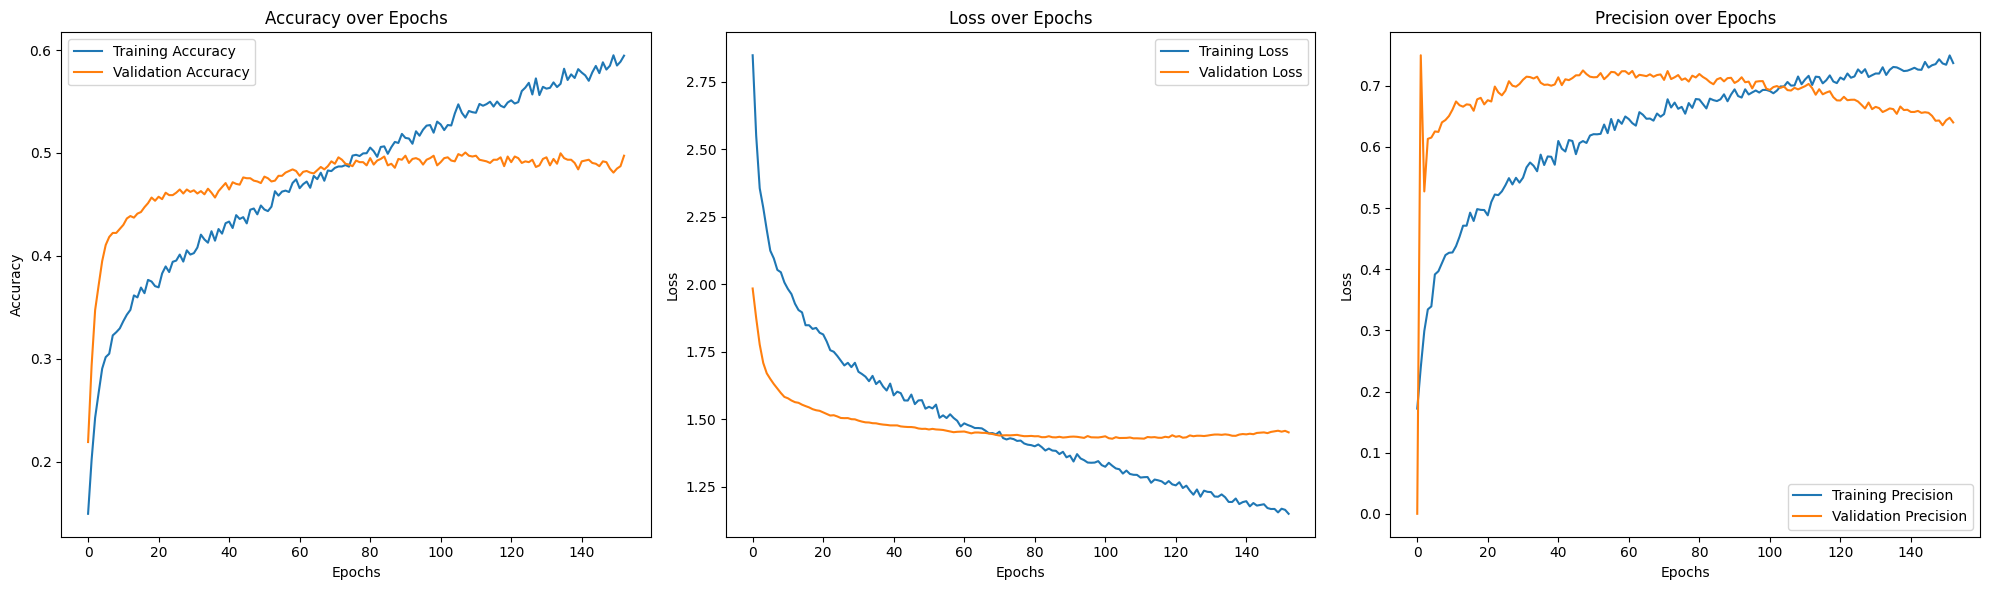

In [14]:
plt.figure(figsize=(20, 6))

# Plot training and validation accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Precision over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

print("Dokładność:", accuracy)
print("Precyzja (macro):", precision)
print("F1 score (macro):", f1)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Dokładność: 0.4959349593495935
Precyzja (macro): 0.4880416335248192
F1 score (macro): 0.4873419294176652


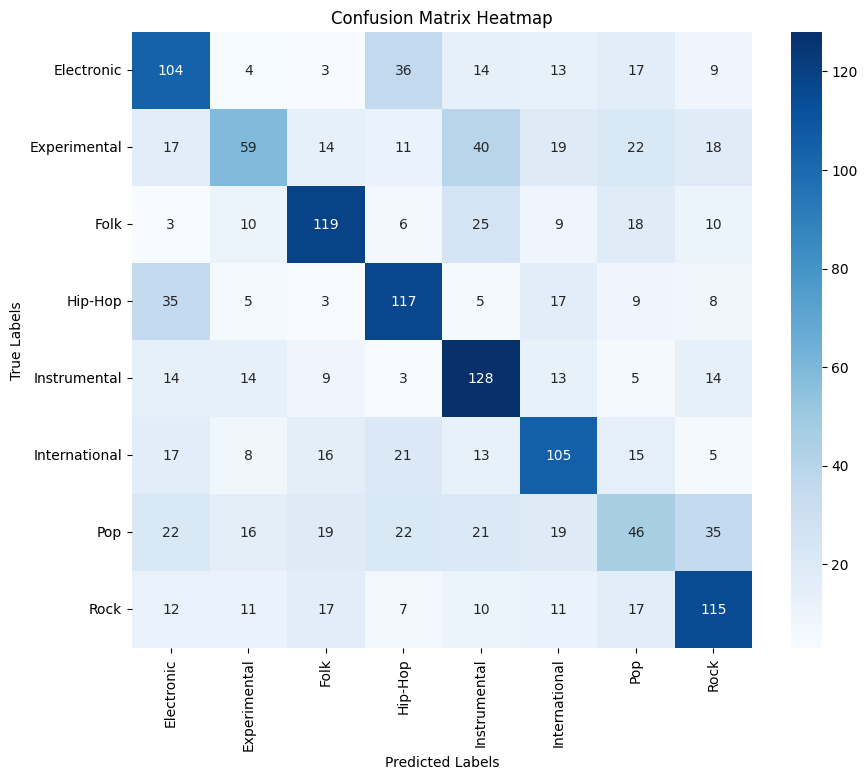

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

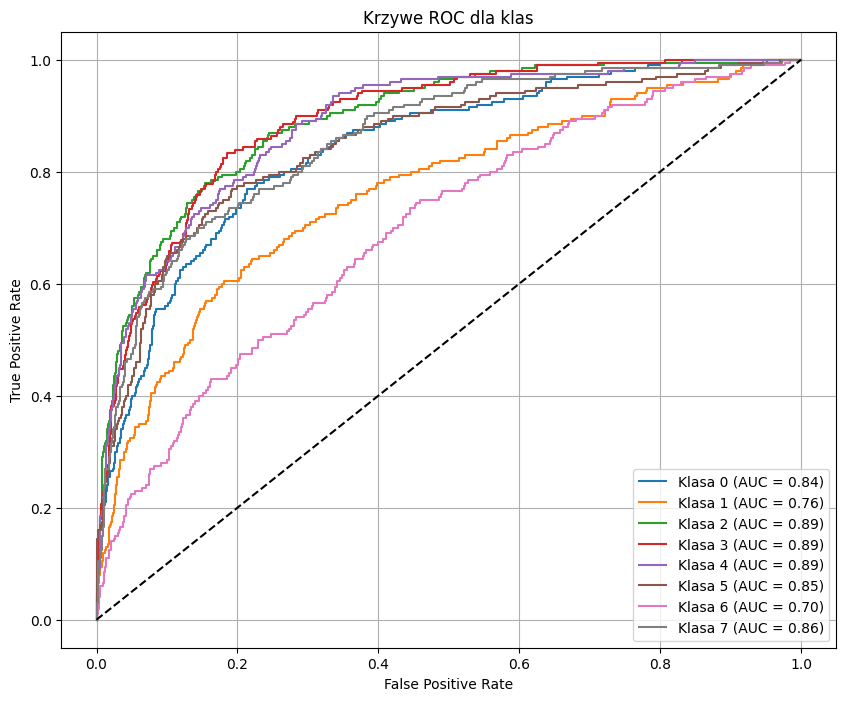

In [19]:
y_true_bin = label_binarize(y_true, classes=range(8))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(8):
    plt.plot(fpr[i], tpr[i], label=f'Klasa {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywe ROC dla klas')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()